In [4]:
#Importing the library
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [5]:
#!pip install d2l==0.16.6 #==> if d2l is not working then setup the environment '''


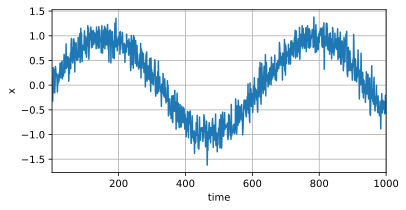

In [6]:
T = 1000  # Generate a total of 1000 points
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [7]:
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i:T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [8]:
# Vanilla MLP architecture
def get_net():
    net = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)])
    return net

In [9]:
loss = tf.keras.losses.MeanSquaredError()

In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out) / 2
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 1.265985
epoch 2, loss: 0.706324
epoch 3, loss: 0.383171
epoch 4, loss: 0.214977
epoch 5, loss: 0.131133


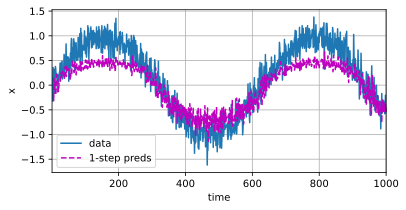

In [12]:
#predictions
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.numpy(), onestep_preds.numpy()], 'time', 'x',
         legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

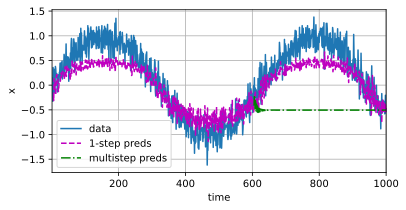

In [13]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(
        tf.reshape(net(tf.reshape(multistep_preds[i - tau:i], (1, -1))), ()))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.numpy(),
    onestep_preds.numpy(), multistep_preds[n_train + tau:].numpy()], 'time',
         'x', legend=['data', '1-step preds',
                      'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

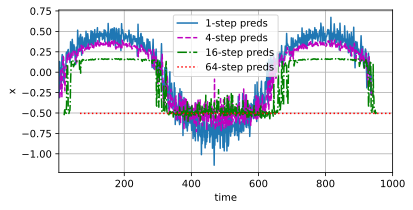

In [14]:
max_steps = 64

features = tf.Variable(tf.zeros((T - tau - max_steps + 1, tau + max_steps)))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i].assign(x[i:i + T - tau - max_steps + 1].numpy())

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i].assign(tf.reshape(net((features[:, i - tau:i])), -1))

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds'
                 for i in steps], xlim=[5, 1000], figsize=(6, 3))